# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.metrics import zero_one_loss

%matplotlib inline

In [2]:
from utils.data_gen import compute_bayes_risk_binary, compute_bayes_risk_binary_label_shift,\
    generate_2d_example

from utils.concentrations import hoeffding_ci_lower_limit,\
    hoeffding_ci_upper_limit
from utils.concentrations import pm_bernstein_ci_upper_limit,\
    pm_bernstein_ci_lower_limit

from utils.concentrations import pm_bernstein_lower_limit, pm_bernstein_upper_limit
from utils.concentrations import pm_hoeffding_upper_limit, pm_hoeffding_lower_limit

from utils.data_gen import LDA_predictor

from utils.concentrations import betting_ci_lower_limit, betting_ci_upper_limit

from utils.tests import Drop_tester,misclas_losses

In [3]:
sns.set(
    style="whitegrid",
    font_scale=1.4,
    rc={
        "lines.linewidth": 2,
        #             "axes.facecolor": ".9",
        'figure.figsize': (12, 6)
    })
sns.set_palette('Set2')
matplotlib.rcParams['text.usetex'] = True

In [4]:
legend_dict = ['$\{0\}$', '$\{1\}$']
clr1 = np.array([193, 142, 206]) / 256
clr2 = np.array([125, 225, 125]) / 256
colors = [clr1, clr2]

color1 = np.array([244, 236, 118]) / 256
color2 = np.array([110, 200, 235]) / 256
color3 = np.array([233, 113, 183]) / 256

In [5]:
%load_ext autoreload
%autoreload 2

# Null vs alternative

In [6]:
mu_1 = np.array([1,0])
mu_0 = np.array([-1,0])
target_prob_class_1 = np.linspace(0.1,0.9,100)

eps_tol = 0.05

In [7]:
risk_source = compute_bayes_risk_binary_label_shift(0.25, 0.25, mu_1,
                                                    mu_0)[0][0]

In [8]:
risk_source

0.1270168302054692

In [9]:
target_risks = list()

In [10]:
for cur_target_prob in target_prob_class_1:
    target_risks += [
        compute_bayes_risk_binary_label_shift(0.25, cur_target_prob, mu_1,
                                              mu_0)[0][0]
    ]
target_risks = np.array(target_risks)

In [11]:
nulls = (target_risks-risk_source<=eps_tol)

In [12]:
target_prob_class_1[np.argmin(nulls == True)]

0.43939393939393945

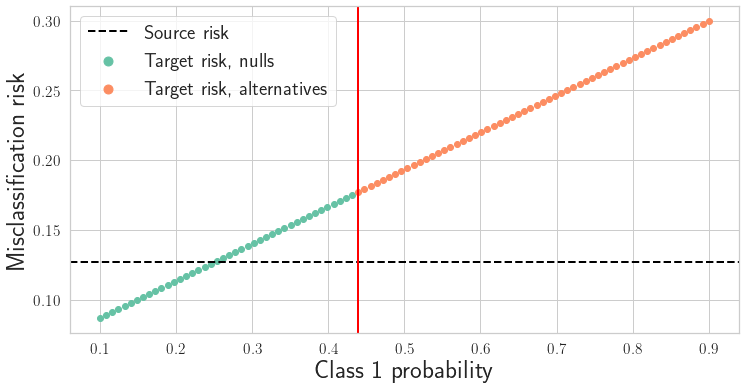

In [14]:
plt.scatter(target_prob_class_1[nulls],
            target_risks[nulls],
            label='Target risk, nulls')
plt.scatter(target_prob_class_1[~nulls],
            target_risks[~nulls],
            label='Target risk, alternatives')
plt.axhline(y=risk_source, linestyle='dashed', c='black', label='Source risk')
plt.axvline(x=target_prob_class_1[np.argmin(nulls == True)], c='red')
plt.legend(loc=2, markerscale=1.5, prop={'size': 20})
plt.ylabel('Misclassification risk', fontsize=25)
plt.xlabel('Class 1 probability', fontsize=25)
# plt.show()
plt.savefig('img/nulls_vs_alternatives.pdf', bbox_inches='tight')

# Estimate number of samples to reject

In [15]:
num_of_repeats = 250
num_of_batches_to_sample = 40

size_of_batch = 50
size_source_sample = 1000

max_num_of_target_samples = num_of_batches_to_sample * size_of_batch

In [16]:
eps_tol

0.05

In [17]:
max_num_of_target_samples

2000

In [18]:
target_cand_probs = np.linspace(0.1,0.9,20)

In [19]:
mu_1 = np.array([1, 0])
mu_0 = np.array([-1, 0])
prob_class_1 = 0.25
prob_class_0 = 1 - prob_class_1
cov = np.eye(2)

In [20]:
clf = LDA_predictor()

clf.mean_class_0 = mu_0
clf.mean_class_1 = mu_1
clf.class_0_prior = prob_class_0
clf.class_1_prior = prob_class_1

In [21]:
tester_hoeffding = Drop_tester()
tester_bernstein = Drop_tester()
tester_betting_bernstein = Drop_tester()
tester_betting = Drop_tester()

tester_hoeffding.eps_tol = eps_tol
tester_hoeffding.target_conc_type = 'pm_hoeffding'
tester_hoeffding.source_conc_type = 'hoeffding'

tester_bernstein.eps_tol = eps_tol
tester_bernstein.source_conc_type = 'pm_bernstein'
tester_bernstein.target_conc_type = 'pm_bernstein'

tester_betting.eps_tol = eps_tol
tester_betting.source_conc_type = 'betting'
tester_betting.target_conc_type = 'betting'

In [22]:
bern_num_rejects = list()
hoef_num_rejects = list()
bet_num_rejects = list()

bern_num_samples_to_reject = list()
hoef_num_samples_to_reject = list()
bet_num_samples_to_reject = list()

In [23]:
for cur_ind, cur_target_prob in enumerate(target_cand_probs):

    bern_num_samples_to_reject += [[]]
    hoef_num_samples_to_reject += [[]]
    bet_num_samples_to_reject += [[]]

    bern_num_rejects += [0]
    hoef_num_rejects += [0]
    bet_num_rejects += [0]

    for cur_sim in range(num_of_repeats):

        X_val_source, y_val_source = generate_2d_example(
            0.25, mu_0, mu_1, size_source_sample)

        y_pred_val = clf.predict(X_val_source)
        ind_loss_source = misclas_losses(y_pred_val, y_val_source)

        tester_hoeffding.estimate_risk_source(ind_loss_source)
        tester_bernstein.estimate_risk_source(ind_loss_source)
        tester_betting.estimate_risk_source(ind_loss_source)

        X_new_target, y_new_target = generate_2d_example(
            cur_target_prob, mu_0, mu_1,
            size_of_batch * num_of_batches_to_sample)

        y_pred_target = clf.predict(X_new_target)
        ind_loss_target = misclas_losses(y_pred_target, y_new_target)

        for cur_batch in range(num_of_batches_to_sample):
            cur_losses = ind_loss_target[0:(cur_batch + 1) * size_of_batch]
            tester_hoeffding.estimate_risk_target(cur_losses)
            
            if tester_hoeffding.test_for_drop():
                hoef_num_rejects[cur_ind] += 1
                hoef_num_samples_to_reject[cur_ind] += [tester_hoeffding.target_num_of_samples_used]
                break
             
        for cur_batch in range(num_of_batches_to_sample):
            cur_losses = ind_loss_target[0:(cur_batch + 1) * size_of_batch]
            tester_bernstein.estimate_risk_target(cur_losses)
            
            if tester_bernstein.test_for_drop():
                bern_num_rejects[cur_ind] += 1
                bern_num_samples_to_reject[cur_ind] += [tester_bernstein.target_num_of_samples_used]
                break
                
        for cur_batch in range(num_of_batches_to_sample):
            cur_losses = ind_loss_target[0:(cur_batch + 1) * size_of_batch]
            tester_betting.estimate_risk_target(cur_losses)
            
            if tester_betting.test_for_drop():
                bet_num_rejects[cur_ind] += 1
                bet_num_samples_to_reject[cur_ind] += [tester_betting.target_num_of_samples_used]
                break

In [24]:
hoef_fraction_rejected = [num_rej / num_of_repeats for num_rej in hoef_num_rejects]
bern_fraction_rejected = [num_rej / num_of_repeats for num_rej in bern_num_rejects]
bet_fraction_rejected = [num_rej / num_of_repeats for num_rej in bet_num_rejects]

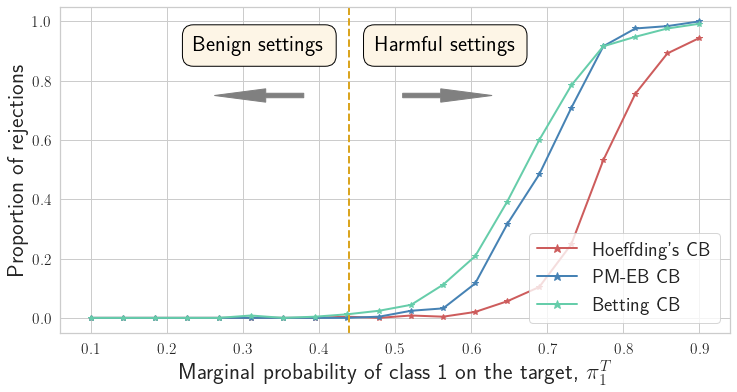

In [109]:
plt.plot(target_cand_probs,
         hoef_fraction_rejected,
         marker='*',
         label='Hoeffding\'s CB',
         color='indianred')
plt.plot(target_cand_probs,
         bern_fraction_rejected,
         marker='*',
         label='PM-EB CB',
         color='steelblue')
plt.plot(target_cand_probs,
         bet_fraction_rejected,
         marker='*',
         label='Betting CB',
         color='mediumaquamarine')
plt.axvline(x=target_prob_class_1[np.argmin(nulls == True)],
            c='goldenrod',
            linestyle='dashed')
plt.text(0.235, 0.9, 'Benign settings', color='black',fontsize= 22, 
        bbox=dict(facecolor='oldlace', edgecolor='black', boxstyle='round,pad=0.5'))
plt.text(0.473, 0.9, 'Harmful settings', color='black',fontsize= 22, 
        bbox=dict(facecolor='oldlace', edgecolor='black', boxstyle='round,pad=0.5'))

plt.arrow(0.38, 0.75, -0.05, 0, color= 'gray',width = 0.015)
plt.arrow(0.51, 0.75, 0.05, 0, color= 'gray',width = 0.015)

legend = plt.legend(loc=4, markerscale=1.5, prop={'size': 20})
legend.get_title().set_fontsize('22')
plt.ylabel('Proportion of rejections', fontsize=23)
plt.xlabel('Marginal probability of class 1 on the target, $\pi_1^T$', fontsize=23)
plt.savefig('img/prop_rej_sim_new_arrows.pdf', bbox_inches='tight')

## number of samples

In [ ]:
hoef_lengths = np.array([len(cur_prob) for cur_prob in hoef_num_samples_to_reject])
bern_lengths = np.array([len(cur_prob) for cur_prob in bern_num_samples_to_reject])
bet_lengths = np.array([len(cur_prob) for cur_prob in bet_num_samples_to_reject])

In [87]:
min_num_rej = 5

In [88]:
hoef_len_ind = (np.array(hoef_lengths) >= min_num_rej).astype('bool')
bern_len_ind = (np.array(bern_lengths) >= min_num_rej).astype('bool')
bet_len_ind = (np.array(bet_lengths) >= min_num_rej).astype('bool')

In [89]:
hoef_avg = np.array([
    np.mean(cur_prob)
    for cur_ind, cur_prob in enumerate(hoef_num_samples_to_reject)
    if hoef_lengths[cur_ind] >= min_num_rej
])

bern_avg = np.array([
    np.mean(cur_prob)
    for cur_ind, cur_prob in enumerate(bern_num_samples_to_reject)
    if bern_lengths[cur_ind] >= min_num_rej
])

bet_avg = np.array([
    np.mean(cur_prob)
    for cur_ind, cur_prob in enumerate(bet_num_samples_to_reject)
    if bet_lengths[cur_ind] >= min_num_rej
])

hoef_stds = np.array([
    np.std(cur_prob)
    for cur_ind, cur_prob in enumerate(hoef_num_samples_to_reject)
    if hoef_lengths[cur_ind] >= min_num_rej
])

bern_stds = np.array([
    np.std(cur_prob)
    for cur_ind, cur_prob in enumerate(bern_num_samples_to_reject)
    if bern_lengths[cur_ind] >= min_num_rej
])

bet_stds = np.array([
    np.std(cur_prob)
    for cur_ind, cur_prob in enumerate(bet_num_samples_to_reject)
    if bet_lengths[cur_ind] >= min_num_rej
])

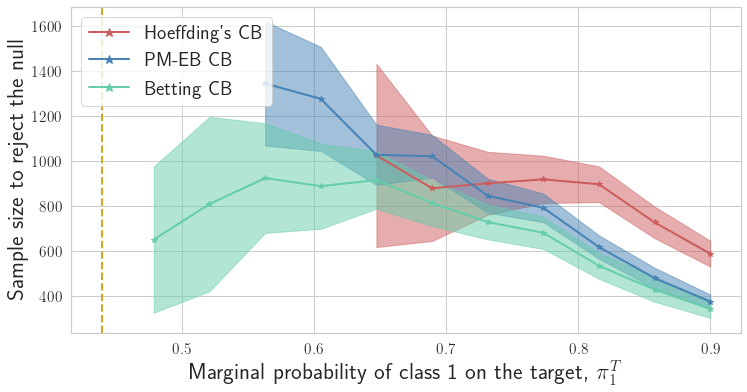

In [164]:
plt.plot(target_cand_probs[hoef_len_ind],
         hoef_avg,
         marker='*',
         label='Hoeffding\'s CB',
         color='indianred')

plt.fill_between(
    target_cand_probs[hoef_len_ind],
    y1=hoef_avg - 2 * hoef_stds / np.sqrt(hoef_lengths[hoef_len_ind]),
    y2=hoef_avg + 2 * hoef_stds / np.sqrt(hoef_lengths[hoef_len_ind]),
    alpha=0.5,
    color='indianred')

plt.plot(target_cand_probs[bern_len_ind],
         bern_avg,
         marker='*',
         label='PM-EB CB',
         color='steelblue')

plt.fill_between(
    target_cand_probs[bern_len_ind],
    y1=bern_avg - 2 * bern_stds / np.sqrt(bern_lengths[bern_len_ind]),
    y2=bern_avg + 2 * bern_stds / np.sqrt(bern_lengths[bern_len_ind]),
    alpha=0.5,
    color='steelblue')

plt.plot(target_cand_probs[bet_len_ind],
         bet_avg,
         marker='*',
         label='Betting CB',
         color='mediumaquamarine')

plt.fill_between(target_cand_probs[bet_len_ind],
                 y1=bet_avg - 2 * bet_stds / np.sqrt(bet_lengths[bet_len_ind]),
                 y2=bet_avg + 2 * bet_stds / np.sqrt(bet_lengths[bet_len_ind]),
                 alpha=0.5,
                 color='mediumaquamarine')

plt.legend(loc=2, markerscale=1.5, prop={'size': 20})
plt.ylabel('Sample size to reject the null', fontsize=23)
plt.xlabel('Marginal probability of class 1 on the target, $\pi_1^T$', fontsize=23)
plt.axvline(x=target_prob_class_1[np.argmin(nulls == True)],
            c='goldenrod',
            linestyle='dashed')
plt.savefig('img/number_of_samples.pdf', bbox_inches='tight')

In [100]:
np.arange(4).tolist()[::-1]

[3, 2, 1, 0]

In [160]:
def spiral(n):
    """
    Function that takes an input and prints out an array filled with numbers in a spiral
    """
    matrix = np.zeros([n, n])
    idx_x = 0
    idx_y = 0
    min_x = 0
    max_x = n - 1
    min_y = 0
    max_y = n - 1
    cand_nums = np.arange(1,n**2+2).astype('int').tolist()[::-1]

    num_to_enter = n**2
    nums_entered = 0
    
    while nums_entered< num_to_enter:
        
        while idx_x == min_x and idx_y < max_y:
            #going right
            cur_num = cand_nums.pop()
            matrix[idx_x, idx_y] = cur_num
            nums_entered+=1
            idx_y += 1
        
            if nums_entered == num_to_enter:
                return matrix
        
        if idx_x == min_x and idx_y == max_y:
            #turn
            cur_num = cand_nums.pop()
            matrix[idx_x, idx_y] = cur_num
            idx_x += 1
            min_x += 1
            nums_entered+=1
            if nums_entered == num_to_enter:
                return matrix

            
        while idx_x < max_x and idx_y == max_y:
            #going down
            cur_num = cand_nums.pop()
            matrix[idx_x, idx_y] = cur_num
            idx_x += 1
            nums_entered+=1
            if nums_entered == num_to_enter:
                return matrix
    
        if idx_x == max_x and idx_y == max_y:
            #turn
            cur_num = cand_nums.pop()
            matrix[idx_x, idx_y] = cur_num
            idx_y -= 1
            max_y -= 1
            nums_entered+=1
            if nums_entered == num_to_enter:
                return matrix
    
        while idx_x == max_x and idx_y > min_y:
            #going left
            cur_num = cand_nums.pop()
            matrix[idx_x, idx_y] = cur_num
            idx_y -= 1
            nums_entered+=1
            if nums_entered == num_to_enter:
                return matrix
            
        if idx_x == max_x and idx_y == min_y:
            #turn
            cur_num = cand_nums.pop()
            matrix[idx_x, idx_y] = cur_num
            idx_x -= 1
            max_x -=1
            nums_entered+=1
            if nums_entered == num_to_enter:
                return matrix
        
        while idx_x > min_x and idx_y == min_y:
            #going up
            cur_num = cand_nums.pop()
            matrix[idx_x, idx_y] = cur_num
            idx_x -= 1
            nums_entered+=1

            if nums_entered == num_to_enter:
                return matrix

        min_y+=1
            
    return matrix

In [162]:
spiral(6)

array([[ 1.,  2.,  3.,  4.,  5.,  6.],
       [20., 21., 22., 23., 24.,  7.],
       [19., 32., 33., 34., 25.,  8.],
       [18., 31., 36., 35., 26.,  9.],
       [17., 30., 29., 28., 27., 10.],
       [16., 15., 14., 13., 12., 11.]])

In [159]:
np.arange(5**2)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

In [104]:
a

array([[0.04495419, 0.01365429, 0.07613206],
       [0.37960429, 0.16858457, 0.143014  ],
       [0.3185095 , 0.6476841 , 0.35369454]])

In [106]:
a[1,2]

0.14301399965925898